# Time Series Models

If we think back to our lecture on the bias-variance tradeoff, a perfect model is not possible.  There will always noise (inexplicable error). A timeseries that is completely random is called white noise, and is written mathematically as:

$$\Large Y_t =  \epsilon_t$$

The error term is randomly distributed around the mean, has constant variance, and no autocorrelation.

In [1]:
# Let's make some white noise!
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

rands = []
for _ in range(1000):
    rands.append(gs(0, 1))
series = pd.Series(rands)

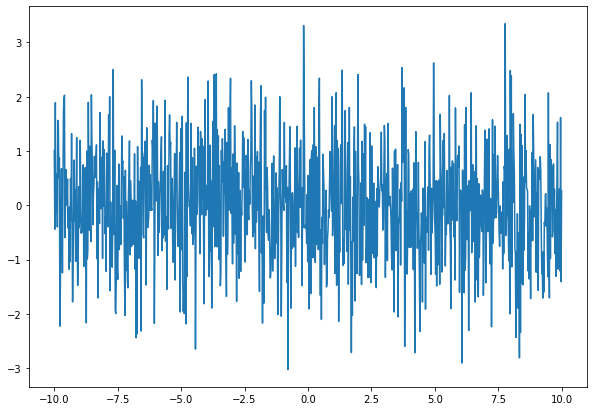

In [2]:
X = np.linspace(-10, 10, 1000)
plt.figure(figsize=(10, 7))
plt.plot(X, series);

We know this data has no true pattern governing its fluctuations (because we coded it with a random function).

Any attempt at a model would be fruitless.  The next point in the series could be any value, completely independent of the previous value.

We will assume that the timeseries data that we are working with is more than just white noise.

# Train Test Split

Let's reimport our chicago gun crime data, and prepare it in the same manner as the last notebook.


In [3]:
ts = pd.read_csv('data/Gun_Crimes_Heat_Map.csv')
ts['Date'] = pd.to_datetime(ts.Date)
ts_minute = ts.groupby('Date').count()['ID']
daily_count = ts_minute.resample('D').sum()
daily_count = daily_count[daily_count < 90]

ts_dr = pd.date_range(daily_count.index[0], daily_count.index[-1])
ts_daily = np.empty(shape=len(ts_dr))
ts_daily = pd.Series(ts_daily)
ts_daily = ts_daily.reindex(ts_dr)
ts_daily = ts_daily.fillna(daily_count)
ts_daily = ts_daily.interpolate()

ts_weekly = ts_daily.resample('W').mean()


Text(0.5, 1.0, 'Weekly Reports of Gun Offenses in Chicago')

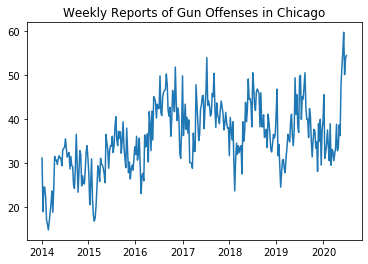

In [4]:
fig, ax = plt.subplots()
ax.plot(ts_weekly)
ax.set_title("Weekly Reports of Gun Offenses in Chicago")

In [6]:
ts_weekly.shape

(339,)

Train test split for a time series is a little different than what we are used to.  Because **chronological order matters**, we cannot randomly sample points in our data.  Instead, we cut off a portion of our data at the end, and reserve it as our test set.

In [7]:
# find the index which allows us to split off 20% of the data
round(ts_weekly.shape[0]*.8)

271

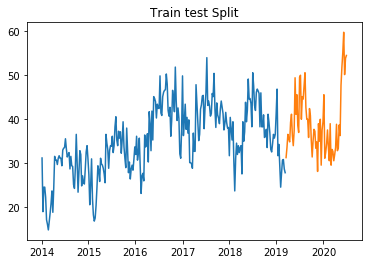

In [8]:
# Define train and test sets according to the index found above
train = ts_weekly[:round(ts_weekly.shape[0]*.8)]
test = ts_weekly[round(ts_weekly.shape[0]*.8):]

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train test Split');

We will now set aside our test set, and build our model on the train.

# Random Walk

A good first attempt at a model for a time series would be to simply predict the next data point with the point previous to it.  

We call this type of time series a random walk, and it is written mathematically like so.

$$\Large Y_t = Y_{t-1} + \epsilon_t$$

$\epsilon$ represents white noise error.  The formula indicates that the difference between a point and a point before it is white noise.

$$\Large Y_t - Y_{t-1}=  \epsilon_t$$

This makes sense, given one way we described making our series stationary was by applying a difference of a lag of 1.

Let's bring back our Chicago gun crime data and make a simple random walk model.

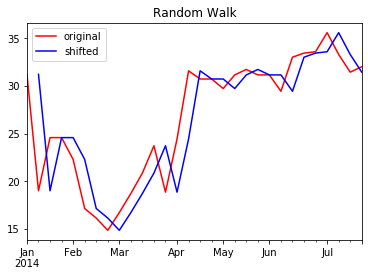

In [9]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
random_walk = train.shift(1)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

For a baseline to compare our later models, lets calculate our **RMSE** for the random walk

In [10]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train[1:], random_walk.dropna())

22.0670566893424

In [11]:
residuals = random_walk - train
mse = (residuals.dropna()**2).sum()/len(residuals-1)
np.sqrt(mse.sum())

4.688883495660368

Now, lets plot the residuals.

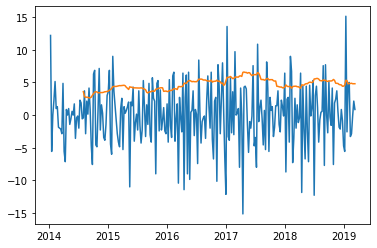

In [12]:
plt.plot(residuals.index, residuals)
plt.plot(residuals.index, residuals.rolling(30).std())

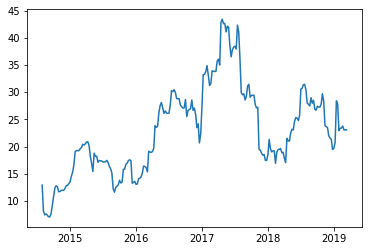

In [13]:
plt.plot(residuals.index, residuals.rolling(30).var())

If we look at the rolling standard deviation of our errors, we can see that the performance of our model varies at different points in time.

That is a result of the trends in our data.

In the previous notebook, we were able to make our series **stationary** by differencing our data. 

Let's repeat that process here. 

In order to make our life easier, we will use statsmodels to difference our data via the **ARIMA** class. 

We will break down what ARIMA is shortly, but for now, we will focus on the I, which stands for **integrated**.  A time series which has been be differenced to become stationary is saidf to have been integrated[1](https://people.duke.edu/~rnau/411arim.htm). 

There is an order parameter in ARIMA with three slots: (p, d, q).  d represents our order of differencing, so putting a one there in our model will apply a first order difference.




In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [15]:
rw = ARIMA(train, (0,1,0)).fit()
rw.predict(typ='levels')

2014-01-12    31.187619
2014-01-19    18.987619
2014-01-26    24.559048
2014-02-02    24.559048
2014-02-09    22.273333
                ...    
2019-02-10    24.559048
2019-02-17    27.844762
2019-02-24    30.701905
2019-03-03    30.844762
2019-03-10    28.701905
Freq: W-SUN, Length: 270, dtype: float64

We can see that the differenced predictions (d=1) are just a random walk

In [16]:
random_walk

2014-01-05          NaN
2014-01-12    31.200000
2014-01-19    19.000000
2014-01-26    24.571429
2014-02-02    24.571429
                ...    
2019-02-10    24.571429
2019-02-17    27.857143
2019-02-24    30.714286
2019-03-03    30.857143
2019-03-10    28.714286
Freq: W-SUN, Length: 271, dtype: float64

In [17]:
# We put a typ='levels' to convert our predictions to remove the differencing performed.
y_hat = rw.predict(typ='levels')
np.sqrt(mean_squared_error(train[1:], y_hat))

4.697542272439977

Visually, our differenced data looks more like white noise:

Text(0.5, 1.0, 'Weekly differenced data')

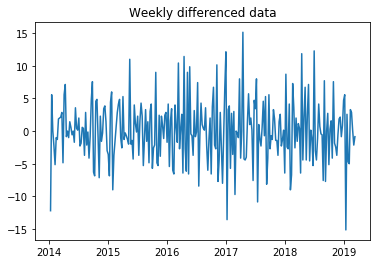

In [18]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data')

By removing the trend from our data, we assume that our data's mean and variance are constant throughout.  But it is not just white noise.  If it were, our models could do no better than random predictions around the mean.  

Our task now is to find **more patterns** in the series.  

We will focus on the data points near to the point in question.  We can attempt to find patterns to how much influence previous points in the sequence have. 

If that made you think of regression, great! What we will be doing is assigning weights, like our betas, to previous points.

# The Autoregressive Model (AR)

Our next attempt at a model is the autoregressive model, which is a timeseries regressed on its previous values

### $y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \varepsilon_{t}$

The above formula is a first order autoregressive model (AR1), which finds the best fit weight $\phi$ which, multiplied by the point previous to a point in question, yields the best fit model. 

In our ARIMA model, the **p** variable of the order (p,d,q) represents the AR term.  For a first order AR model, we put a 1 there.

In [19]:
ar_1 = ARIMA(train, (1,1,0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

2014-01-12    31.198536
2014-01-19    22.556496
2014-01-26    22.944514
2014-02-02    24.569538
2014-02-09    22.950500
                ...    
2019-02-10    26.027893
2019-02-17    26.896905
2019-02-24    29.879050
2019-03-03    30.813585
2019-03-10    29.337404
Freq: W-SUN, Length: 270, dtype: float64

The ARIMA class comes with a nice summary table.  

In [20]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -789.078
Method:                       css-mle   S.D. of innovations              4.497
Date:                Mon, 13 Jul 2020   AIC                           1584.156
Time:                        13:25:03   BIC                           1594.952
Sample:                    01-12-2014   HQIC                          1588.491
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.212     -0.007      0.994      -0.417       0.414
ar.L1.D.y     -0.2917      0.059     -4.954      0.000      -0.407      -0.176
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4285           +0.0000j            3.4285            0.5000
-----------------------------------------------------------------------------
"""

But, as you may notice, the output does not include RMSE.

It does include AIC. We briefly touched on AIC with linear regression.  It is a metric with a strict penalty applied to we used models with too many features.  A better model has a lower AIC.

Let's compare the first order autoregressive model to our Random Walk.

In [21]:
rw_model = ARIMA(train, (0,1,0)).fit()
rw_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -800.814
Method:                           css   S.D. of innovations              4.698
Date:                Mon, 13 Jul 2020   AIC                           1605.628
Time:                        13:26:37   BIC                           1612.825
Sample:                    01-12-2014   HQIC                          1608.518
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0124      0.286     -0.043      0.965      -0.573       0.548
==============================================================================
"""

In [22]:
print(f'Random Walk AIC: {rw.aic}')
print(f'AR(1,1,0) AIC: {ar_1.aic}' )


Random Walk AIC: 1605.628111571946
AR(1,1,0) AIC: 1584.1562780341596


Our AIC for the AR(1) model is lower than the random walk, indicating improvement.  

Before abandoning it for AIC, let's just make sure the RMSE is lower as well.

In [23]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train[1:], y_hat_ar1))


4.502200686486479

In [24]:
y_hat_rw = rw.predict(typ='levels')
np.sqrt(mean_squared_error(train[1:], y_hat_rw))

4.697542272439977

Checks out. RMSE is lower as well.

Autoregression, as we said before, is a regression of a time series on lagged values of itself.  

From the summary, we see the coefficient of the 1st lag:

In [25]:
ar_1.arparams

array([-0.29167099])

We come close to reproducing this coefficients with linear regression, with slight differences due to how statsmodels performs the regression. 

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())
print(lr.coef_)

[-0.28545641]


We can also factor in more than just the most recent point.
$$\large y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \phi_{2}y_{t-2}+ \varepsilon_{t}$$

We refer to the order of our AR model by the number of lags back we go.  The above formula refers to an **AR(2)** model.  We put a 2 in the p position of the ARIMA class order

In [27]:
ar_2 = ARIMA(train, (2,1,0)).fit()


ar_2.predict(typ='levels')

2014-01-12    31.205021
2014-01-19    22.538712
2014-01-26    26.234072
2014-02-02    22.860489
2014-02-09    23.160197
                ...    
2019-02-10    27.929185
2019-02-17    28.163787
2019-02-24    28.626233
2019-03-03    29.929740
2019-03-10    29.490555
Freq: W-SUN, Length: 270, dtype: float64

In [28]:
print(rw.aic)
print(ar_1.aic)
print(ar_2.aic)

1605.628111571946
1584.1562780341596
1559.6786866515151


Our AIC improves with more lagged terms.

# Moving Average Model (MA)

The next type of model is based on error.  The idea behind the moving average model is to make a prediciton based on how far off we were the day before.

$$\large Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

The moving average model is a pretty cool idea. We make a prediction, see how far off we were, then adjust our next prediction by a factor of how far off our pervious prediction was.

In our ARIMA model, the q term of our order (p,d,q) refers to the MA component. To use one lagged error, we put 1 in the q position.


In [33]:
ma_1 = ARIMA(train, (0,0,1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

TypeError: predict() got an unexpected keyword argument 'typ'

In [32]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  271
Model:                     ARMA(0, 1)   Log Likelihood                -850.315
Method:                       css-mle   S.D. of innovations              5.571
Date:                Mon, 13 Jul 2020   AIC                           1706.631
Time:                        13:35:41   BIC                           1717.437
Sample:                    01-05-2014   HQIC                          1710.970
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.1182      0.572     61.446      0.000      33.998      36.238
ma.L1.y        0.6914      0.037     18.488      0.000       0.618       0.765
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4463           +0.0000j            1.4463            0.5000
-----------------------------------------------------------------------------
"""

Let's see if we can reproduce the predictions above

In [34]:
y_hat_manual = ((train - y_hat)*ma_1.maparams[0] +train.mean()).shift()
y_hat_manual

2014-01-05          NaN
2014-01-12          NaN
2014-01-19    26.691420
2014-01-26    38.979099
2014-02-02    35.126853
                ...    
2019-02-10    31.669708
2019-02-17    37.398691
2019-02-24    37.102364
2019-03-03    35.225628
2019-03-10    33.645219
Freq: W-SUN, Length: 271, dtype: float64

Let's look at the 1st order MA model with a 1st order difference

In [35]:
ma_1 = ARIMA(train, (0,1,1)).fit()

print(rw.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)


1605.628111571946
1584.1562780341596
1559.6786866515151
1561.6598781567423


It performs better than a 1st order AR, but worse than a 2nd order

Just like our AR models, we can lag back as far as we want. Our MA(2) model would use the past two lagged terms:

$$\large Y_t = \mu +\epsilon_t + \theta_{t-1} * \epsilon_{t-1} + \theta_2 * \epsilon_{t-2}$$

and our MA term would be two.

In [36]:
ma_2 = ARIMA(train, (0,1,2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

2014-01-12    31.214962
2014-01-19    22.331460
2014-01-26    25.804441
2014-02-02    24.659319
2014-02-09    23.462409
                ...    
2019-02-10    29.178173
2019-02-17    29.956664
2019-02-24    30.679594
2019-03-03    30.652318
2019-03-10    29.480737
Freq: W-SUN, Length: 270, dtype: float64

In [37]:
print(rw.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

1605.628111571946
1584.1562780341596
1559.6786866515151
1561.6598781567423
1555.9026879743085


# ARMA

We don't have to limit ourselves to just AR or MA.  We can use both AR terms and MA terms.

for example, an ARMA(2,1) model is given by:

 $$\large Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$


In [38]:
arma_21 = ARIMA(train, (2,1,1)).fit()

In [39]:
print(rw.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(arma_21.aic)

1605.628111571946
1584.1562780341596
1559.6786866515151
1561.6598781567423
1558.0010402540224


Best performance so far.

# ACF and PACF

We have been able to reduce our AIC by chance, adding fairly random p,d,q terms.

We have two tools to help guide us in these decisions: the autocorrelation and partial autocorrelation functions.

## PACF

In general, a partial correlation is a **conditional correlation**. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. If $Y_t$ is correlated with $Y_{t-1}$, and $Y_{t-1}$ is equally correlated with $Y_{t-2}$, then we should also expect to find correlation between $Y_t$ and $Y_{t-2}$. Thus, the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags. The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.



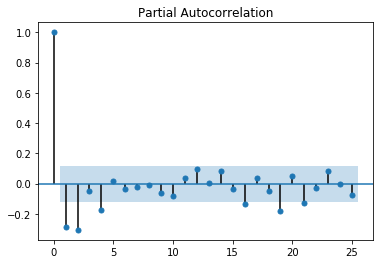

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train.diff().dropna());

The shaded area of the graph is the convidence interval.  When the correlation drops into the shaded area, that means there is no longer statistically significant correlation between lags.

For an AR process, we run a linear regression on lags according to the order of the AR process. The coefficients calculated factor in the influence of the other variables.   

Since the PACF shows the direct effect of previous lags, it helps us choose AR terms.  If there is a significant positive value at a lag, consider adding an AR term according to the number that you see.

Some rules of thumb: 

    - A sharp drop after lag "k" suggests an AR-K model.
    - A gradual decline suggests an MA.

## ACF

The autocorrelation plot of our time series is simply a version of the correlation plots we used in linear regression.  Our features this time are prior points in the time series, or the **lags**. 

We can calculate a specific covariance ($\gamma_k$) with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y_t})(y_{t+k}-\bar{y_{t+k}})}$

In [42]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

,lag_0,lag_1
2014-01-05,31.200000,NaN
2014-01-12,19.000000,31.200000
2014-01-19,24.571429,19.000000
2014-01-26,24.571429,24.571429
2014-02-02,22.285714,24.571429


In [43]:
gamma_1 = sum(((df['lag_0'][1:]-df.lag_0[1:].mean())*(df['lag_1'].dropna()-df.lag_1.dropna().mean())))/(len(df.lag_1)-1)
gamma_1

47.273931188936466

We then comput the Pearson correlation:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

In [44]:
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

0.8107715076960059

In [45]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.810772,0.731753,0.725590,0.673699,0.663134
lag_1,0.810772,1.000000,0.810224,0.731427,0.725210,0.672541
lag_2,0.731753,0.810224,1.000000,0.810003,0.731024,0.724364
lag_3,0.725590,0.731427,0.810003,1.000000,0.809768,0.730663
lag_4,0.673699,0.725210,0.731024,0.809768,1.000000,0.809579
lag_5,0.663134,0.672541,0.724364,0.730663,0.809579,1.000000


<BarContainer object of 6 artists>

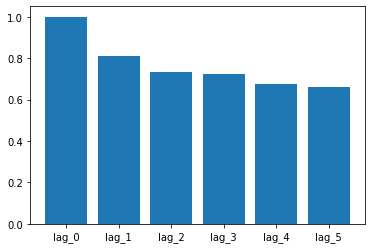

In [46]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']))

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

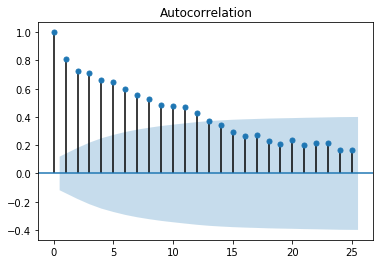

In [48]:
# Original data

plot_acf(train);

The above autocorrelation shows that there is correlation between lags up to about 12 weeks back.  

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a **first difference** of the data to remove this autocorrelation.

This makes sense, since we are trying to capture the effect of recent lags in our ARMA models, and with high correlation between distant lags, our models will not come close to the true process.

Generally, we use an ACF to predict MA terms.
Moving Average models are using the error terms of the predicitons to calculate the next value.  This means that the algorithm does not incorporate the direct effect of the previous value. It models what are sometimes called **impulses** or **shocks** whose effect takes into accounts for the propogation of correlation from one lag to the other. 


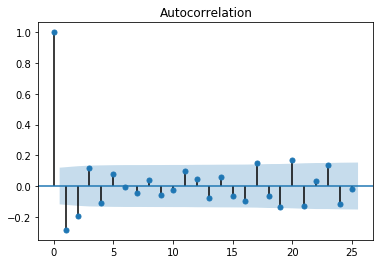

In [49]:
plot_acf(train.diff().dropna());

This autocorrelation plot can now be used to get an idea of a potential MA term.  Our differenced series shows negative significant correlation at lag of 1 suggests adding 1 MA term.  There is also a statistically significant 2nd, term, so adding another MA is another possibility.


> If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms. [Duke](https://people.duke.edu/~rnau/411arim3.htm#signatures)

Rule of thumb:
    
  - If the autocorrelation shows negative correlation at the first lag, try adding MA terms.
    
    

![alt text](./img/armaguidelines.png)

The plots above suggest that we should try a 1st order differenced MA(1) or MA(2) model on our weekly gun offense data.

This aligns with our AIC scores from above.

The ACF can be used to identify the possible structure of time series data. That can be tricky going forward as there often isn’t a single clear-cut interpretation of a sample autocorrelation function.

# auto_arima

Luckily for us, we have a Python package that will help us determine optimal terms.

In [50]:
from pmdarima import auto_arima

auto_arima(train, start_p=0, start_q=0, max_p=6, max_q=3, seasonal=False, trace=True)

ModuleNotFoundError: No module named 'pmdarima'

According to auto_arima, our optimal model is a first order differenced, AR(1)MA(2) model.

Let's plot our training predictions.

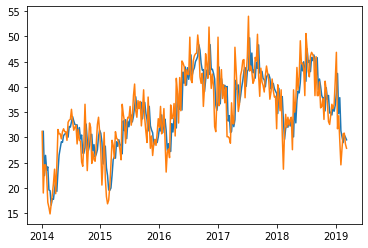

In [51]:
aa_model = ARIMA(train, (1,1,2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train)

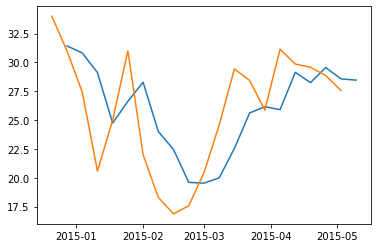

In [52]:
# Let's zoom in:

fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70])

In [53]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -771.573
Method:                       css-mle   S.D. of innovations              4.212
Date:                Mon, 13 Jul 2020   AIC                           1553.146
Time:                        14:02:32   BIC                           1571.138
Sample:                    01-12-2014   HQIC                          1560.371
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.112      0.108      0.914      -0.207       0.231
ar.L1.D.y     -0.5158      0.152     -3.397      0.001      -0.813      -0.218
ma.L1.D.y      0.1080      0.141      0.767      0.444      -0.168       0.384
ma.L2.D.y     -0.4519      0.068     -6.614      0.000      -0.586      -0.318
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9389           +0.0000j            1.9389            0.5000
MA.1           -1.3728           +0.0000j            1.3728            0.5000
MA.2            1.6119           +0.0000j            1.6119            0.0000
-----------------------------------------------------------------------------
"""

# Test

Now that we have chosen our parameters, let's try our model on the test set.

In [54]:
test

2019-03-17    31.285714
2019-03-24    33.571429
2019-03-31    36.571429
2019-04-07    35.571429
2019-04-14    34.857143
                ...    
2020-05-31    55.157143
2020-06-07    59.771429
2020-06-14    50.142857
2020-06-21    53.857143
2020-06-28    54.500000
Freq: W-SUN, Length: 68, dtype: float64

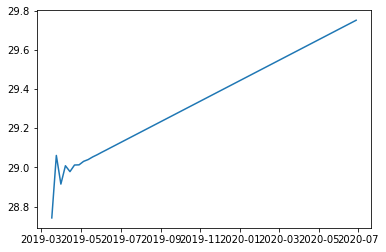

In [55]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test)


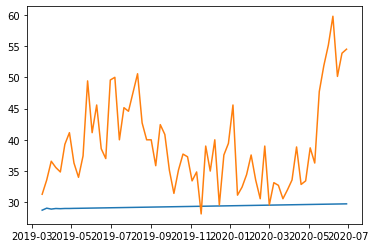

In [56]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)

In [57]:
np.sqrt(mean_squared_error(test, y_hat_test))

12.100167204815785

Our predictions on the test set certainly leave something to be desired.  

Let's take another look at our autocorrelation function of the original series.

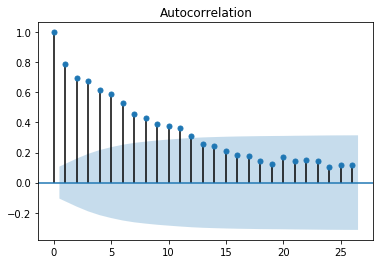

In [59]:
plot_acf(ts_weekly);

Let's increase the lags

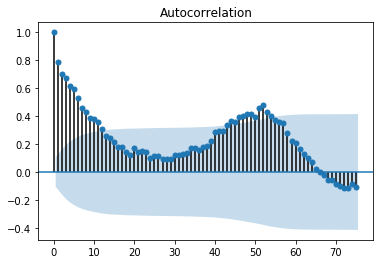

In [60]:
plot_acf(ts_weekly, lags=75);

There seems to be a wave of correlation at around 50 lags.
What is going on?

![verkempt](https://media.giphy.com/media/l3vRhBz4wCpJ9aEuY/giphy.gif)

# SARIMA

Looks like we may have some other forms of seasonality.  Luckily, we have SARIMA, which stands for Seasonal Auto Regressive Integrated Moving Average.  That is a lot.  The statsmodels package is actually called SARIMAX.  The X stands for exogenous, and we are only dealing with endogenous variables, but we can use SARIMAX as a SARIMA.


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

A seasonal ARIMA model is classified as an **ARIMA(p,d,q)x(P,D,Q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms
     
    **P** = number of seasonal autoregressive (SAR) terms 
    **D** = number of seasonal differences 
    **Q** = number of seasonal moving average (SMA) terms

In [62]:
import itertools
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))


Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [199]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:1406.5914910305441
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:1039.6273546182113
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:1055.4512482807704
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:1038.419076265242
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:1326.266685805947
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:978.1309943041055
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:1005.6947621192127
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:980.71332272061
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:1373.0472465290327
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:1019.1651883767508
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:1024.5423831365738
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:1018.4857412836736
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:1320.7264572171368
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:973.5518935855749
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:988.5066193103887
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:975.3115937856937


Let's try the third from the bottom, ARIMA(1, 1, 1)x(0, 1, 1, 52)12 - AIC:973.5518935855749

In [63]:
sari_mod =SARIMAX(train,order=(1,1,1),seasonal_order=(0,1,1,52),enforce_stationarity=False,enforce_invertibility=False).fit()


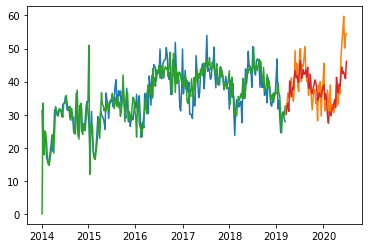

In [64]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.plot(y_hat_train)
ax.plot(y_hat_test)

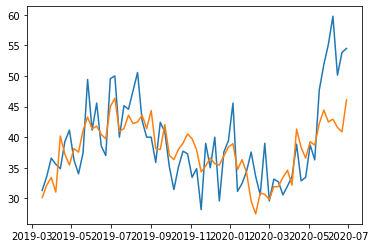

In [65]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test)
ax.plot(y_hat_test)


In [66]:
np.sqrt(mean_squared_error(test, y_hat_test))

5.0673442561861135

# Forecast

Lastly, let's predict into the future.

To do so, we refit to our entire training set.

In [67]:
sari_mod =SARIMAX(ts_weekly,order=(1,1,1),seasonal_order=(0,1,1,52),enforce_stationarity=False,enforce_invertibility=False).fit()

In [68]:
forecast = sari_mod.forecast(steps = 52)

Text(0.5, 1.0, 'Chicago Gun Crime Predictions\n One Year out')

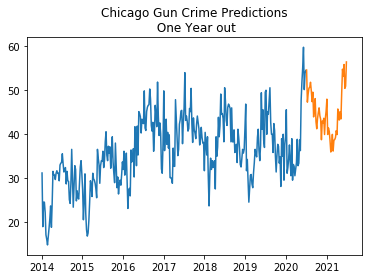

In [69]:
fig, ax = plt.subplots()

ax.plot(ts_weekly)
ax.plot(forecast)
ax.set_title('Chicago Gun Crime Predictions\n One Year out')